In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
from distutils.dir_util import copy_tree

copy_tree("/gdrive/My Drive/Colab Notebooks/Traffic-signs", "/content/")

['/content/signnames.csv', '/content/kaggle.json']

# Dataset Download and Extraction from kaggle

In [0]:
!pip install kaggle -qU
!mkdir ~/.kaggle

In [0]:
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 99% 604M/612M [00:10<00:00, 51.2MB/s]
100% 612M/612M [00:11<00:00, 58.2MB/s]


In [0]:
from zipfile import ZipFile

zip_file = ZipFile('/content/gtsrb-german-traffic-sign.zip', 'r')
zip_file.extractall('/content/traffic')
zip_file.close()

# Required libraries download 

In [7]:
!pip install -qU imgaug==0.2.6
!pip install -qU opencv-contrib-python
!pip install -qU scikit-image
!pip install -qU imutils

     |████████████████████████████████| 634kB 6.0MB/s 
     |████████████████████████████████| 34.2MB 83kB/s 
     |████████████████████████████████| 12.4MB 213kB/s 


# Model Building

In [0]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [0]:
def build_model(width, height, depth, classes):
    model = Sequential()
    inputShape = (height, width, depth)
    channelDim = -1
    
    model.add(Conv2D(8, (5, 5), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=channelDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization(axis=channelDim))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization(axis=channelDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization(axis=channelDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # second set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes, activation='relu'))
    model.add(Activation("softmax"))

    return model
    

# Image Preprocessing building data loader

In [0]:
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import classification_report

from skimage import transform
from skimage import exposure
from skimage import io

import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [0]:
def load_split(basePath, csvPath):
    data = []
    labels = []
    rows = open(csvPath).read().strip().split("\n")[1:]
    random.shuffle(rows)
    
    for i, row in enumerate(rows):
        (label, imagePath) = row.strip().split(",")[-2:]
        imagePath = os.path.sep.join([basePath, imagePath])
        image = io.imread(imagePath)

        # resize the image to be 32x32 pixels, ignoring aspect ratio,
        # and then perform Contrast Limited Adaptive Histogram
        # Equalization (CLAHE)
        
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)

        data.append(image)
        labels.append(int(label))
    
    print(f"Processed {i} total images")
        
    data = np.array(data)
    labels = np.array(labels)
    
    return (data, labels)

In [0]:
# constants

NUM_EPOCHS = 30
INIT_LR = 1e-3
batch_size = 64

In [0]:
# load the label names

labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

dataset_path = r'/content/traffic'
train_path = r"/content/traffic/Train.csv"
test_path = r"/content/traffic/Test.csv"

In [14]:
# load the training and testing data
print("Loading training and testing data...")
(trainX, trainY) = load_split(dataset_path, train_path)
(testX, testY) = load_split(dataset_path, test_path)

Loading training and testing data...
Processed 39208 total images
Processed 12629 total images


In [0]:
# scale the images to the range of [0, 1]

trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

In [16]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(39209, 32, 32, 3)
(39209,)
(12630, 32, 32, 3)
(12630,)


In [17]:
# one-hot encode the training and testing labels

numLabels = len(np.unique(trainY))
print(numLabels)
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)

43


In [18]:
print(trainY.shape)
print(testY.shape)

(39209, 43)
(12630, 43)


In [0]:
# accounting for skewness in the labeled data

classTotals = trainY.sum(axis=0)
# print(classTotals)
classWeight = classTotals.max() / classTotals
# print(classWeight)
classWeight = {i: x for i, x  in enumerate(classWeight)}

# for key, val in classWeight.items():
#     print(key, val, end="||")

In [0]:
# adding image augmentation

train_datagen = ImageDataGenerator(
    rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest"
)

train_generator = train_datagen.flow(trainX, trainY, batch_size=batch_size)

In [0]:
optimizer = Adam(lr=INIT_LR, decay=INIT_LR/(NUM_EPOCHS*0.5))

model = build_model(width=32, height=32, depth=3, classes=numLabels)

model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [22]:
# model Training

history = model.fit(
    train_generator,
    steps_per_epoch=trainX.shape[0] // batch_size,
    validation_data=(testX, testY),
    epochs=NUM_EPOCHS,
    class_weight=classWeight
)

Epoch 1/30
612/612 [==============================] - 28s 46ms/step - loss: 7.8462 - accuracy: 0.1686 - val_loss: 6.9659 - val_accuracy: 0.0391
Epoch 2/30
612/612 [==============================] - 27s 44ms/step - loss: 4.4272 - accuracy: 0.4238 - val_loss: 1.1214 - val_accuracy: 0.6496
Epoch 3/30
612/612 [==============================] - 27s 44ms/step - loss: 3.0761 - accuracy: 0.5539 - val_loss: 0.7651 - val_accuracy: 0.7528
Epoch 4/30
612/612 [==============================] - 32s 52ms/step - loss: 2.4304 - accuracy: 0.6309 - val_loss: 0.9052 - val_accuracy: 0.6838
Epoch 5/30
612/612 [==============================] - 27s 43ms/step - loss: 2.0064 - accuracy: 0.6893 - val_loss: 0.6013 - val_accuracy: 0.8029
Epoch 6/30
612/612 [==============================] - 27s 44ms/step - loss: 1.7189 - accuracy: 0.7297 - val_loss: 0.5102 - val_accuracy: 0.8154
Epoch 7/30
612/612 [==============================] - 27s 43ms/step - loss: 1.5024 - accuracy: 0.7634 - val_loss: 0.7703 - val_accuracy:

In [23]:
# evaluate model

predictions = model.predict(testX, batch_size=batch_size)
print(classification_report(testY.argmax(axis=1), 
                            predictions.argmax(axis=1), target_names=labelNames))

                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.36      1.00      0.52        60
                              Speed limit (30km/h)       0.59      0.95      0.73       720
                              Speed limit (50km/h)       0.81      0.63      0.71       750
                              Speed limit (60km/h)       0.65      0.95      0.77       450
                              Speed limit (70km/h)       0.95      0.90      0.92       660
                              Speed limit (80km/h)       0.94      0.41      0.57       630
                       End of speed limit (80km/h)       0.96      0.80      0.87       150
                             Speed limit (100km/h)       0.96      0.67      0.79       450
                             Speed limit (120km/h)       0.92      0.68      0.78       450
                                        No passing       0.91      0.95      0.

In [24]:
# saving model

model.save(r"output/trafficsignnet.model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: output/trafficsignnet.model/assets


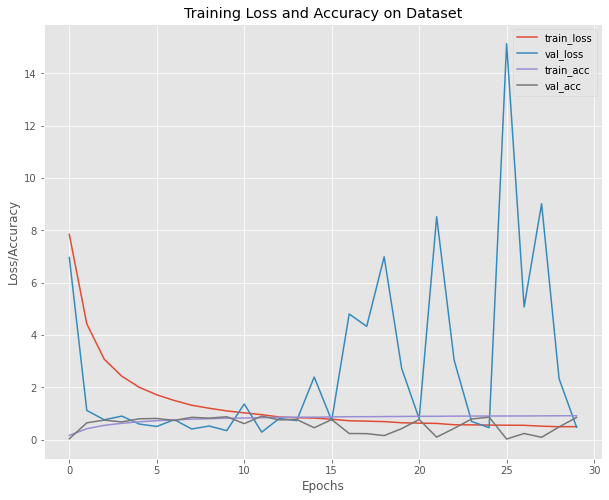

In [25]:
%matplotlib inline

N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(10, 8))
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.show()

In [0]:
import shutil

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)
            
copytree(r"/content/output", r"/gdrive/My Drive/Colab Notebooks/Traffic-signs/output")

# Prediction on sample images

In [0]:
from tensorflow.keras.models import load_model
import cv2
from imutils import paths
import imutils
from google.colab.patches import cv2_imshow

In [0]:
saved_model_path = r"output/trafficsignnet.model"

model = load_model(saved_model_path)

In [29]:
# load the label names
labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]

# grab the paths to the input images, shuffle them, and grab a sample
print("Predicting...")
imagePaths = list(paths.list_images('/content/traffic/Test'))
random.shuffle(imagePaths)
imagePaths = imagePaths[:25]
for (i, imagePath) in enumerate(imagePaths):
    image = io.imread(imagePath)
    image = transform.resize(image, (32, 32))
    image = exposure.equalize_adapthist(image, clip_limit=0.1)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    preds = model.predict(image)
    j = preds.argmax(axis=1)[0]
    label = labelNames[j]
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=128)
    cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    p = os.path.sep.join([r"/content/examples", f"{i}.png"])
    cv2.imwrite(p, image)

print("Done")

Predicting...
Done
